# Visualization of ECoG Dataset Results

This script visualizes the neural-surprisal correlation for the [open ECoG dataset](https://doi.org/10.1101/2025.02.14.638352):

- **Topographic map of M400c amplitude** (corresponding to *Figure 7A*)
- **Time-course of M400c activity** (corresponding to *Figure 7B*)

These visualizations are adapted from the [podcast-ecog-tutorials](https://github.com/hassonlab/podcast-ecog-tutorials).


## loading package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_markers
import pickle
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", message="Random effects covariance is singular")

def FontSetting():
    plt.rcParams.update(
        {'font.size': 10,
          'font.family': ['Arial'],
          'font.weight': 'normal',
          # 'legend.fontsize': 'x-small',
          'legend.fontsize': 'medium',
          'axes.labelsize': 'Large',
          'axes.titlesize': 'Large',
          'axes.titleweight': 'normal',
          })
    plt.rcParams['svg.fonttype'] = 'none'
FontSetting()

## Main script

### Loading calculated neural-surprisal correlation

In [ ]:
# data loading
ch_name_list, coords_list, cc_surp_list = [], [], []
subjs = ["01", "02", "03", "04", "05", "06", "07", "08", "09"]
fs_re = 32
for subj in subjs:
    with open(f"./Calculated/NeuralSurp_{subj}.pickle", "rb") as input_file:
        data_reading = pickle.load(input_file)
        ch_name_list.append(data_reading['ch_name'])
        coords_list.append(data_reading['coords'])
        cc_surp_list.append(data_reading['cc_surp'])
        
ch_names_np = np.concatenate(ch_name_list)
coords_np = np.concatenate(coords_list)

lags = np.arange(-2 * fs_re, 2 * fs_re+1) / fs_re # specify the lags
cc_surp_ = [tmp.reshape((-1, len(lags), tmp.shape[1]), order='F') for tmp in cc_surp_list]
cc_surp_3 = np.concatenate(cc_surp_, 0)

clr_posis = np.array([[168, 218, 220], [230, 57, 70], [255, 255, 0], [29, 53, 87]])/255
name_posis = ['all', 'noninitial', 'noninitial-distri', 'sent-initial', 'chunk-effect']
t_interest = (lags>.3) & (lags<0.5)


### func for visualization

In [3]:
from scipy.spatial import KDTree
from nilearn import datasets, image

def get_coord_atlas_labels(
    coords: np.array, atlas_map: str, atlas_labels: list) -> list:

    atlas_map = image.load_img(atlas_map)
    atlas_image = atlas_map.get_fdata().astype(int)

    # find non-zero labels
    image_label_coords = np.nonzero(atlas_image)

    # transform label indices to MNI space
    atlas_coords = np.vstack(
        image.coord_transform(*image_label_coords, atlas_map.affine)).T

    tree = KDTree(atlas_coords)
    _, nearest_neighbor = tree.query(coords, k=1)

    # look up neighbor index in map
    x = image_label_coords[0][nearest_neighbor]
    y = image_label_coords[1][nearest_neighbor]
    z = image_label_coords[2][nearest_neighbor]

    # convert map index to label
    elec_label_ids = atlas_image[x, y, z]
    elec_labels = [atlas_labels[i] for i in elec_label_ids]

    return elec_labels

def DefROI():
    ROIs = {
    'PrCG': ['G_precentral'],
    'SMG': ['G_pariet_inf-Supramar', 'G_temp_sup-Plan_tempo', 'G_pariet_inf-Angular'],
    'MFG': ['G_front_middle'],
    'EAC': ['G_and_S_subcentral',  'G_temp_sup-G_T_transv', 'S_circular_insula_inf', 'G_Ins_lg_and_S_cent_ins', 'S_temporal_transverse', 'Lat_Fis-post', 'S_temporal_sup'],
    'STG': ['G_temp_sup-Lateral'],
    'IFG': ['G_front_inf-Triangul', 'G_front_inf-Opercular', 'G_front_inf-Orbital'],
    'TP': ['Pole_temporal', 'G_temporal_inf'],
    'MTG': ['G_temporal_middle', 'G_oc-temp_med-Parahip']
    }
    return ROIs

import statsmodels.formula.api as smf
def LME_Test(ini_v, non_v):
    p_t = []
    for t_tmp in range(non_v.shape[1]):
        # print(t_tmp)
        sensor_num_tmp = non_v.shape[0]
        df_tmp = {
            'Sensors': list(range(sensor_num_tmp)) * 2,  
            'Group':  ['ini'] * sensor_num_tmp + ['non'] * sensor_num_tmp,      
            'Value': list(ini_v[:, t_tmp])+list(non_v[:, t_tmp]),                         
        }
        # Model specification
        model = smf.mixedlm("Value ~ Group", data=df_tmp, groups=df_tmp['Sensors'])
        result = model.fit( maxiter=1000)
        p_t.append(result.pvalues.values[1]) 
        # # Print the results
        # print(result.summary())
    return np.array(p_t)


### sensors selection

In [4]:
amp_ = np.mean(cc_surp_3[:, t_interest, 0], axis=-1)
common_sigmask = amp_ > 0.01

cc_surp_3_mask = cc_surp_3[common_sigmask]
ch_names_np_mask = ch_names_np[common_sigmask]
coords_np_mask = coords_np[common_sigmask]

amp_mask_ = np.mean(cc_surp_3_mask[:, t_interest, 0], axis=-1)
sorted_idx_mask = np.argsort(amp_mask_)

### topomap and chunk-effect

C:\Users\xians\AppData\Local\Temp\ipykernel_22364\2742684871.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm_full = plt.cm.get_cmap("coolwarm")


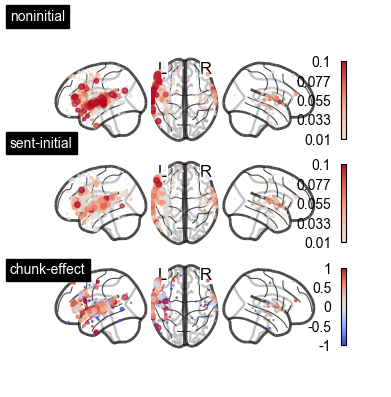

In [5]:
from matplotlib.colors import LinearSegmentedColormap
coolwarm_full = plt.cm.get_cmap("coolwarm")
warm_half = LinearSegmentedColormap.from_list(
    "warm_half", [coolwarm_full(i) for i in np.linspace(0.5, 1, 256)]
)

# topomap
f, ax = plt.subplots(3, 1, layout="constrained", figsize=(3.8, 3.8))

amp_ = np.mean(cc_surp_3[:, t_interest, 0], axis=-1)
sorted_idx = np.argsort(amp_)
for plt_i, posi_i in enumerate([1, 3]):
    if posi_i == 0:
        values = cc_surp_3[:, t_interest, :1].mean(axis=1)
    elif posi_i == 1:
        values = cc_surp_3[:, t_interest, 1:2].mean(axis=1)
    elif posi_i == 2:
        values = cc_surp_3[:, t_interest, -2:-1].mean(axis=1)
    elif posi_i == 3:
        values = cc_surp_3[:, t_interest, -1:].mean(axis=1)

    display = plot_markers(
        values[sorted_idx].mean(1), coords_np[sorted_idx],
        node_size=np.logspace(-6, 1.2, len(sorted_idx)),
        # node_size=5,
        display_mode='lzr', node_cmap=warm_half, 
        colorbar=True, 
        node_vmin=0.01, node_vmax=0.1,
        axes=ax[plt_i], annotate=True)
    display.title(name_posis[posi_i], x=0, y=1.05, size=10)

# chunk effects
non_N400 = cc_surp_3_mask[:, t_interest, 1:2].mean(axis=1)
ini_N400 = cc_surp_3_mask[:, t_interest, -1:].mean(axis=1)
non_N400[non_N400<0.0] = 0
ini_N400[non_N400<0.0] = 0
chunk_effects = (non_N400**2 - ini_N400**2)/(non_N400**2+ini_N400**2)

display = plot_markers(
    chunk_effects[sorted_idx_mask[-len(sorted_idx_mask)//2:]], 
    coords_np_mask[sorted_idx_mask[-len(sorted_idx_mask)//2:]],
    node_size=np.logspace(-10, 1.2, len(sorted_idx))[-len(sorted_idx_mask)//2:], 
    # node_size=5, 
    display_mode='lzr', 
    node_cmap='coolwarm', 
    colorbar=True, node_vmin=-1, node_vmax=1, axes=ax[2])
display.title(name_posis[-1], x=0, y=1.05, size=10)
plt.show()
f.savefig('./result_plot/TopoMap.png', dpi=300)

### atlas analyses

In [6]:
# get atlas
atlas = datasets.fetch_atlas_destrieux_2009()
# Set up a mapping from index -> label
indices = atlas['labels'].index
names = atlas['labels'].name
atlas_labels = {idx: name for idx, name in zip(indices, names)}

# define ROI
ROIs = DefROI()

# get brain region
original_elec_labels = get_coord_atlas_labels(coords_np_mask, atlas['maps'], atlas_labels)
# strip the hemisphere tag from the labels to group left and right hemispheres together
elec_labels = [label.split()[1] for label in original_elec_labels]

print(f"There are {len(elec_labels)} electrodes.")

There are 403 electrodes.


C:\Users\xians\AppData\Local\Temp\ipykernel_22364\439205496.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


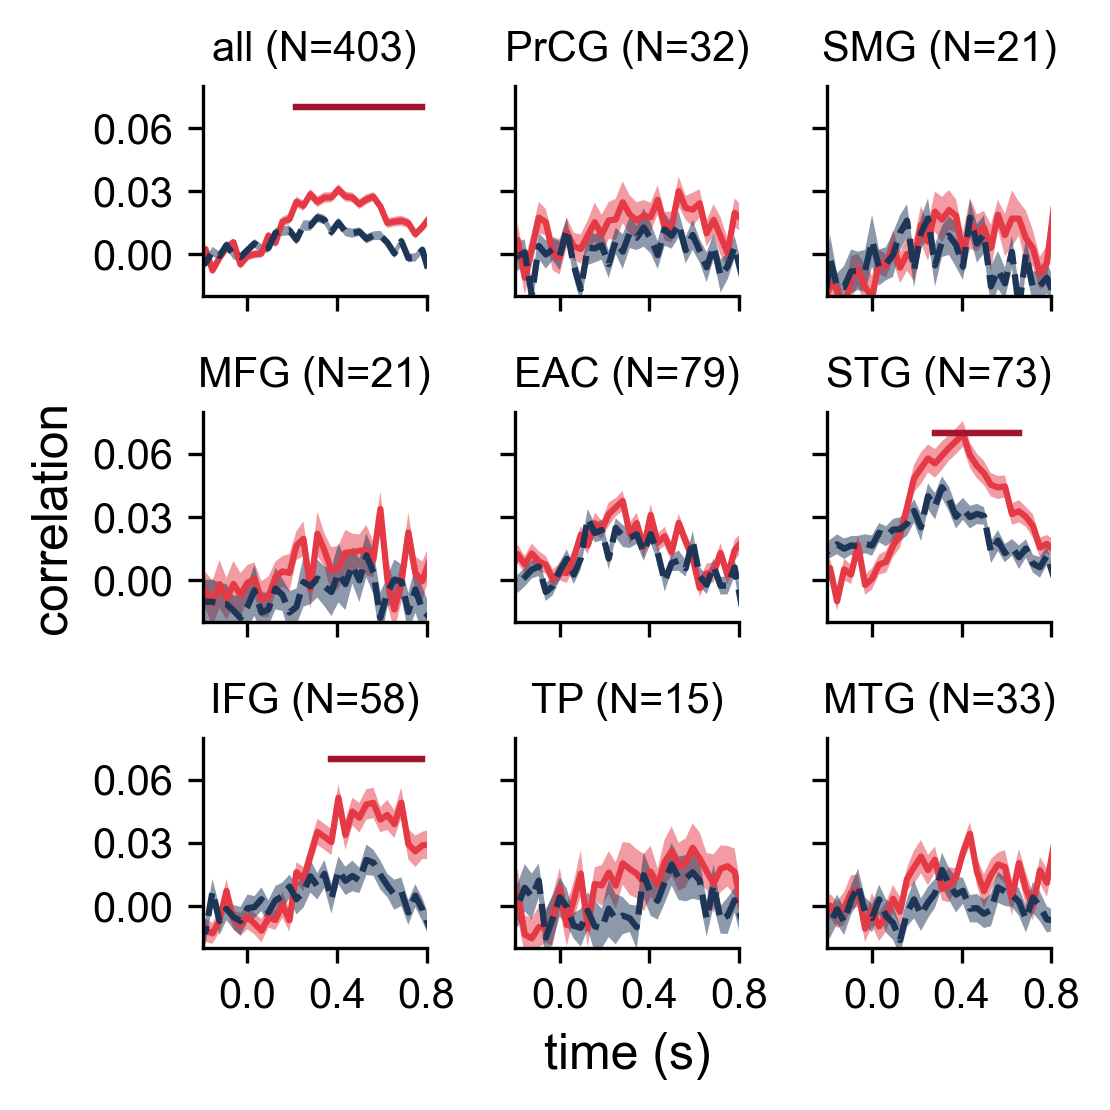

In [7]:
amp_ = np.mean(cc_surp_3_mask[:, t_interest, 0], axis=-1)
common_sigmask = amp_ > -np.inf

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, dpi=300, figsize=(3.8, 3.8))
# for each ROIs
ROIs_tmp = {'all':1}.update(ROIs)
for roi, ax in zip({**{'all':1}, **ROIs}, axes.ravel()):
# for roi, ax in zip({**{'all':1}}, axes.ravel()):
    if roi=='all':
        roi_mask = common_sigmask
    else:
        roi_mask = np.isin(elec_labels, ROIs[roi])
        roi_mask = roi_mask & common_sigmask
    count = roi_mask.sum()
    data_ = cc_surp_3_mask[roi_mask]

    for posi_i in [1, 3]:
        if posi_i == 0:
            data_tmp = data_[:, :, :1].mean(-1)
        elif posi_i == 1:
            data_tmp = data_[:, :, 1:2].mean(-1)
        elif posi_i == 2:
            data_tmp = data_[:, :, -2:-1].mean(-1)
        elif posi_i == 3:
            data_tmp = data_[:, :, -1:].mean(-1)

        ax.set_title(f'{roi} (N={count})', fontsize=10)
        mean = data_tmp.mean(0)
        err = data_tmp.std(0) / np.sqrt(data_tmp.shape[0])
        ax.fill_between(lags, mean - err, mean + err, alpha=0.5, facecolor=clr_posis[posi_i])
        if posi_i==3:
            ax.plot(lags, mean, ls='dashed', label=name_posis[posi_i], color=clr_posis[posi_i])
        else:
            ax.plot(lags, mean, label=name_posis[posi_i], color=clr_posis[posi_i])

        ax.set_xlim([-.2, .8])
        ax.set_xticks(np.arange(-0, 1, 0.4))
        ax.set_yticks(np.arange(-0.0, .065, 0.03))
        ax.set_ylim([-.02, 0.08])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # sig test
        test_t = (lags>=-0.2) & (lags<=0.8)
        non_v = data_[:, test_t, 1:2].mean(-1) 
        ini_v = data_[:, test_t, -1:].mean(-1) 
        p_lme = LME_Test(ini_v, non_v)

        h_lme = np.ones_like(p_lme)*0.07
        h_lme[p_lme > 0.01] = np.nan
        ax.plot(lags[test_t], h_lme, color='#A2142F')

axes[2, 1].set_xlabel("time (s)")
axes[1, 0].set_ylabel("correlation")
plt.tight_layout()
fig.show()
fig.savefig('./result_plot/BrainRegion.png', dpi=300)